# Loan Default Rates by Market Analysis Plan

## Major Assumptions
Default defined as `status = 'default'` or `'written_off'`. Default rate calculated on matured loans only (excluding active). Markets: Kenya, Philippines, Mexico, India.

## Plan
- [x] Data exploration and preparation
  - [x] Identify default definition criteria and market segmentation variables
  - [x] Assess data completeness across time periods and markets
- [x] Calculate default rates by market
  - [x] Compute default rates with appropriate denominators (count vs. dollar-weighted)
- [x] Trend analysis and visualization
  - [x] Create time series of default rates by market (monthly)
  - [x] Build comparative visualizations highlighting market divergence patterns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (12, 6), 'figure.dpi': 100, 'font.size': 11,
    'axes.titlesize': 14, 'axes.labelsize': 12, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e', 'axes.edgecolor': '#272336',
    'axes.labelcolor': '#e9eaeb', 'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e', 'legend.edgecolor': '#272336',
    'legend.labelcolor': '#e9eaeb', 'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6', 
          'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163', 'green': '#4ca86f'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect and load loans data
engine = create_engine(os.environ['TALA_CONNECTION_URL'])
df = pd.read_sql("SELECT * FROM public.loans", engine)
engine.dispose()

# Data prep
df['disbursed_at'] = pd.to_datetime(df['disbursed_at'])
df['due_date'] = pd.to_datetime(df['due_date'])
df['market'] = df['market'].str.title()
df['is_default'] = df['status'].isin(['default', 'written_off']).astype(int)

print(f"Total loans: {len(df):,}")
print(f"\nStatus distribution:\n{df['status'].value_counts()}")
print(f"\nMarket distribution:\n{df['market'].value_counts()}")

Total loans: 25,000

Status distribution:
status
repaid          12282
active          11499
default           611
written_off       405
restructured      203
Name: count, dtype: int64

Market distribution:
market
Kenya          7537
Philippines    6171
Mexico         6162
India          5130
Name: count, dtype: int64


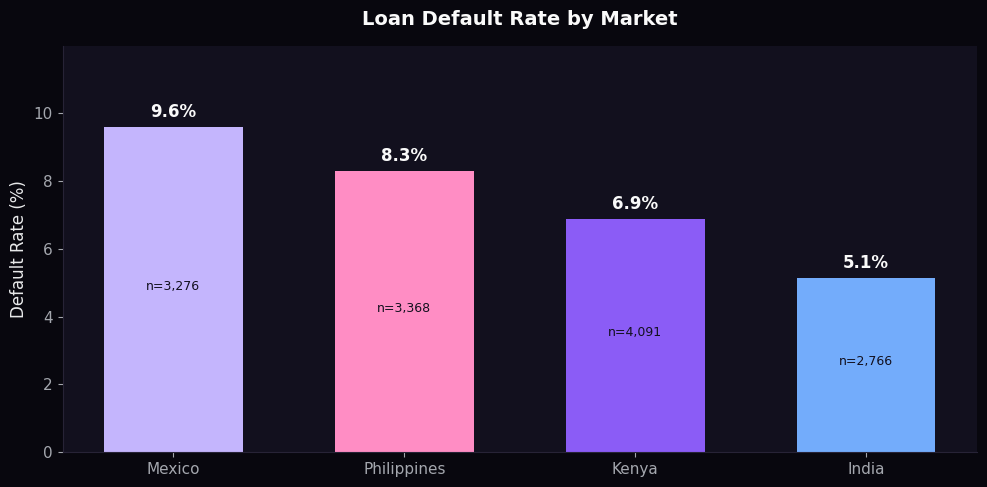

In [2]:
# Filter to matured loans only (exclude active - they haven't had chance to default yet)
matured = df[df['status'] != 'active'].copy()

# Default rate by market
market_stats = matured.groupby('market').agg(
    total_loans=('id', 'count'),
    defaults=('is_default', 'sum'),
    total_amount=('amount_usd', 'sum'),
    default_amount=('amount_usd', lambda x: x[matured.loc[x.index, 'is_default'] == 1].sum())
).reset_index()

market_stats['default_rate'] = (market_stats['defaults'] / market_stats['total_loans'] * 100).round(2)
market_stats = market_stats.sort_values('default_rate', ascending=False)

# Plot default rate by market
fig, ax = plt.subplots(figsize=(10, 5))
colors = [CATEGORICAL_PALETTE[i] for i in range(len(market_stats))]
bars = ax.bar(market_stats['market'], market_stats['default_rate'], color=colors, width=0.6)

for bar, rate, n in zip(bars, market_stats['default_rate'], market_stats['total_loans']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold', color='#FAFAFA')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
            f'n={n:,}', ha='center', fontsize=9, color='#12101e')

ax.set_ylabel('Default Rate (%)')
ax.set_title('Loan Default Rate by Market', fontweight='bold', pad=15)
ax.set_ylim(0, max(market_stats['default_rate']) * 1.25)
plt.tight_layout()
plt.show()

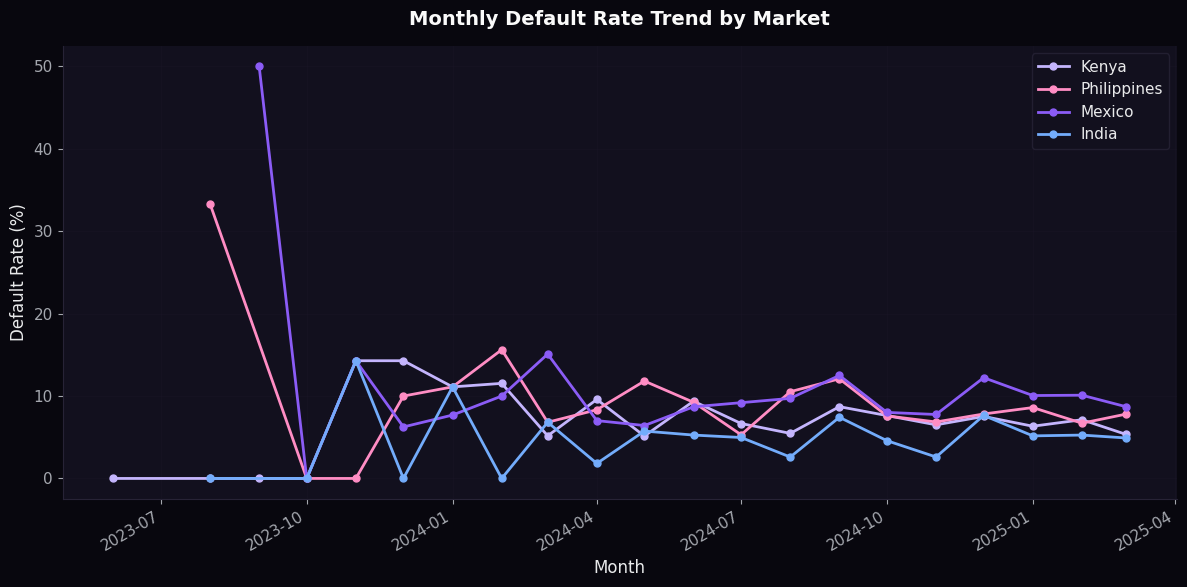

In [3]:
# Monthly default rate trend by market
matured['month'] = matured['disbursed_at'].dt.to_period('M')

monthly_trend = matured.groupby(['month', 'market']).agg(
    loans=('id', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
monthly_trend['default_rate'] = (monthly_trend['defaults'] / monthly_trend['loans'] * 100)
monthly_trend['month_dt'] = monthly_trend['month'].dt.to_timestamp()

# Plot trend
fig, ax = plt.subplots(figsize=(12, 6))
market_colors = {'Kenya': CATEGORICAL_PALETTE[0], 'Philippines': CATEGORICAL_PALETTE[1], 
                 'Mexico': CATEGORICAL_PALETTE[2], 'India': CATEGORICAL_PALETTE[3]}

for market in ['Kenya', 'Philippines', 'Mexico', 'India']:
    data = monthly_trend[monthly_trend['market'] == market].sort_values('month_dt')
    ax.plot(data['month_dt'], data['default_rate'], marker='o', markersize=5,
            linewidth=2, label=market, color=market_colors[market])

ax.set_xlabel('Month')
ax.set_ylabel('Default Rate (%)')
ax.set_title('Monthly Default Rate Trend by Market', fontweight='bold', pad=15)
ax.legend(loc='upper right', frameon=True)
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

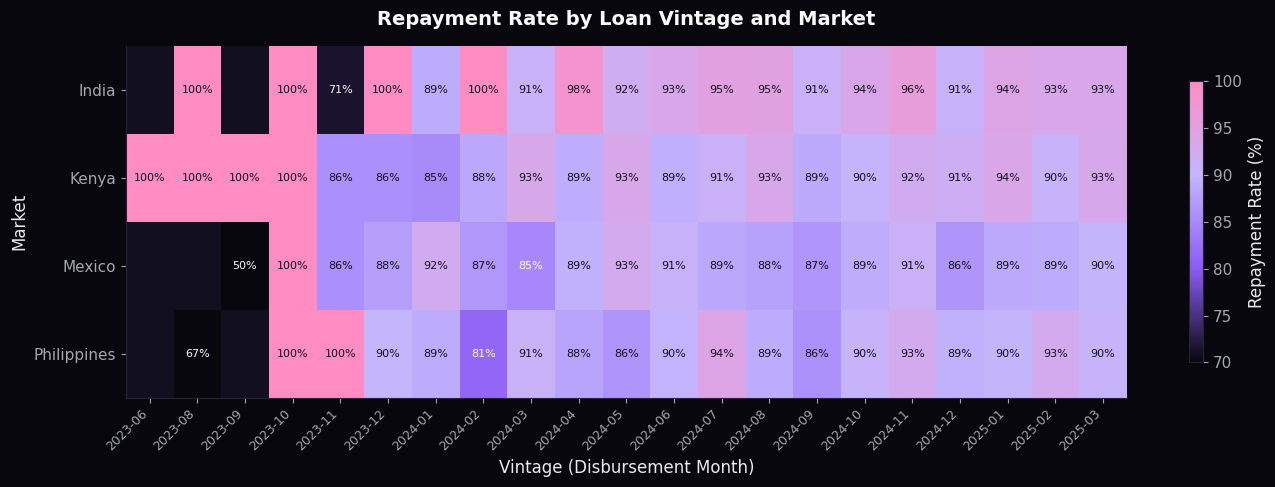

In [4]:
# Repayment rate by loan vintage (month disbursed) and market
# Repayment rate = repaid loans / total matured loans

matured['vintage'] = matured['disbursed_at'].dt.to_period('M')

vintage_stats = matured.groupby(['vintage', 'market']).agg(
    total_loans=('id', 'count'),
    repaid=('status', lambda x: (x == 'repaid').sum())
).reset_index()
vintage_stats['repayment_rate'] = (vintage_stats['repaid'] / vintage_stats['total_loans'] * 100)

# Pivot for heatmap
pivot = vintage_stats.pivot(index='market', columns='vintage', values='repayment_rate')
pivot = pivot[sorted(pivot.columns)]  # Sort by vintage

# Plot heatmap
from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

fig, ax = plt.subplots(figsize=(14, 5))
im = ax.imshow(pivot.values, cmap=sp_cmap, aspect='auto', vmin=70, vmax=100)

# Labels
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([str(c) for c in pivot.columns], rotation=45, ha='right', fontsize=9)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)

# Annotate cells
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.values[i, j]
        if not np.isnan(val):
            color = '#12101e' if val > 85 else '#FAFAFA'
            ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=8, color=color)

cbar = plt.colorbar(im, ax=ax, shrink=0.8, label='Repayment Rate (%)')
ax.set_title('Repayment Rate by Loan Vintage and Market', fontweight='bold', pad=15)
ax.set_xlabel('Vintage (Disbursement Month)')
ax.set_ylabel('Market')
plt.tight_layout()
plt.show()

In [5]:
# Load model scores and join with loans
scores = pd.read_sql("SELECT * FROM public.model_scores", create_engine(os.environ['TALA_CONNECTION_URL']))

# Merge with loan outcomes
model_df = scores.merge(df[['id', 'status', 'is_default', 'market', 'disbursed_at']], 
                        left_on='loan_id', right_on='id', suffixes=('', '_loan'))

# Filter to matured loans for accuracy assessment
model_matured = model_df[model_df['status'] != 'active'].copy()

# Approval rates by model version
approval_stats = model_df.groupby('model_version').agg(
    total_decisions=('id', 'count'),
    approved=('approval_decision', lambda x: (x == 'approved').sum())
).reset_index()
approval_stats['approval_rate'] = (approval_stats['approved'] / approval_stats['total_decisions'] * 100).round(1)

# Default rates among approved loans (by version)
approved_matured = model_matured[model_matured['approval_decision'] == 'approved']
default_by_version = approved_matured.groupby('model_version').agg(
    loans=('id', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
default_by_version['default_rate'] = (default_by_version['defaults'] / default_by_version['loans'] * 100).round(1)

# Merge stats
version_stats = approval_stats.merge(default_by_version, on='model_version')
print("Model Performance by Version:")
print(version_stats[['model_version', 'approval_rate', 'default_rate']].to_string(index=False))

Model Performance by Version:
model_version  approval_rate  default_rate
           v3           66.7          10.4
           v4           70.8          10.4


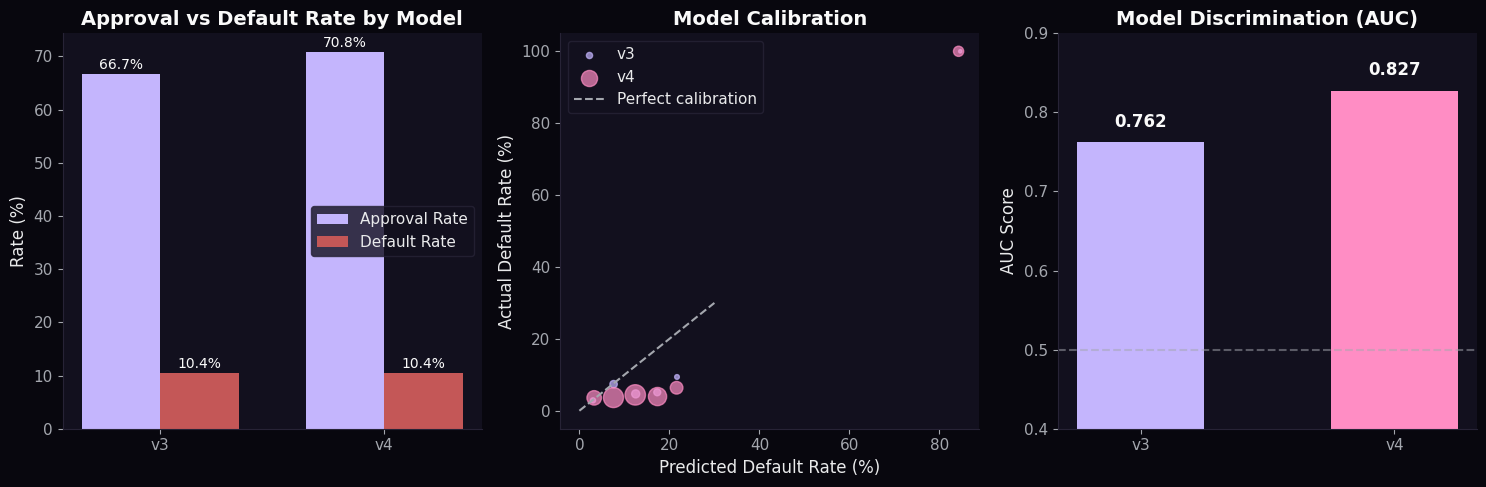


Model Metrics:
model_version   AUC  Brier Score
           v3 0.762       0.0589
           v4 0.827       0.0481


In [7]:
# Model calibration: predicted vs actual default rates by probability bucket
from sklearn.metrics import roc_auc_score, brier_score_loss

approved_matured = model_matured[model_matured['approval_decision'] == 'approved'].copy()
approved_matured['prob_bucket'] = pd.cut(approved_matured['predicted_default_prob'], 
                                          bins=[0, 0.05, 0.10, 0.15, 0.20, 0.30, 1.0],
                                          labels=['0-5%', '5-10%', '10-15%', '15-20%', '20-30%', '30%+'])

calibration = approved_matured.groupby(['model_version', 'prob_bucket'], observed=True).agg(
    loans=('id', 'count'),
    actual_defaults=('is_default', 'sum'),
    avg_predicted=('predicted_default_prob', 'mean')
).reset_index()
calibration['actual_rate'] = (calibration['actual_defaults'] / calibration['loans'] * 100)
calibration['predicted_rate'] = (calibration['avg_predicted'] * 100)

# Calculate AUC and Brier score by version
metrics = []
for version in approved_matured['model_version'].unique():
    subset = approved_matured[approved_matured['model_version'] == version]
    auc = roc_auc_score(subset['is_default'], subset['predicted_default_prob'])
    brier = brier_score_loss(subset['is_default'], subset['predicted_default_prob'])
    metrics.append({'model_version': version, 'AUC': round(auc, 3), 'Brier Score': round(brier, 4)})

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Approval rate vs default rate by version
ax1 = axes[0]
x = np.arange(len(version_stats))
w = 0.35
ax1.bar(x - w/2, version_stats['approval_rate'], w, label='Approval Rate', color=COLORS['primary'])
ax1.bar(x + w/2, version_stats['default_rate'], w, label='Default Rate', color=COLORS['red'])
ax1.set_xticks(x)
ax1.set_xticklabels(version_stats['model_version'])
ax1.set_ylabel('Rate (%)')
ax1.set_title('Approval vs Default Rate by Model', fontweight='bold')
ax1.legend()
for i, (ar, dr) in enumerate(zip(version_stats['approval_rate'], version_stats['default_rate'])):
    ax1.text(i - w/2, ar + 1, f'{ar}%', ha='center', fontsize=10, color='#FAFAFA')
    ax1.text(i + w/2, dr + 1, f'{dr}%', ha='center', fontsize=10, color='#FAFAFA')

# 2. Calibration plot
ax2 = axes[1]
for i, version in enumerate(['v3', 'v4']):
    data = calibration[calibration['model_version'] == version]
    ax2.scatter(data['predicted_rate'], data['actual_rate'], s=data['loans']/10, 
                color=CATEGORICAL_PALETTE[i], label=version, alpha=0.7)
ax2.plot([0, 30], [0, 30], '--', color='#a4a7ae', label='Perfect calibration')
ax2.set_xlabel('Predicted Default Rate (%)')
ax2.set_ylabel('Actual Default Rate (%)')
ax2.set_title('Model Calibration', fontweight='bold')
ax2.legend()

# 3. AUC comparison
ax3 = axes[2]
metrics_df = pd.DataFrame(metrics)
bars = ax3.bar(metrics_df['model_version'], metrics_df['AUC'], color=[CATEGORICAL_PALETTE[0], CATEGORICAL_PALETTE[1]], width=0.5)
ax3.axhline(y=0.5, color='#a4a7ae', linestyle='--', alpha=0.5, label='Random (0.5)')
ax3.set_ylabel('AUC Score')
ax3.set_title('Model Discrimination (AUC)', fontweight='bold')
ax3.set_ylim(0.4, 0.9)
for bar, auc in zip(bars, metrics_df['AUC']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{auc:.3f}', 
             ha='center', fontsize=12, fontweight='bold', color='#FAFAFA')

plt.tight_layout()
plt.show()

print("\nModel Metrics:")
print(pd.DataFrame(metrics).to_string(index=False))

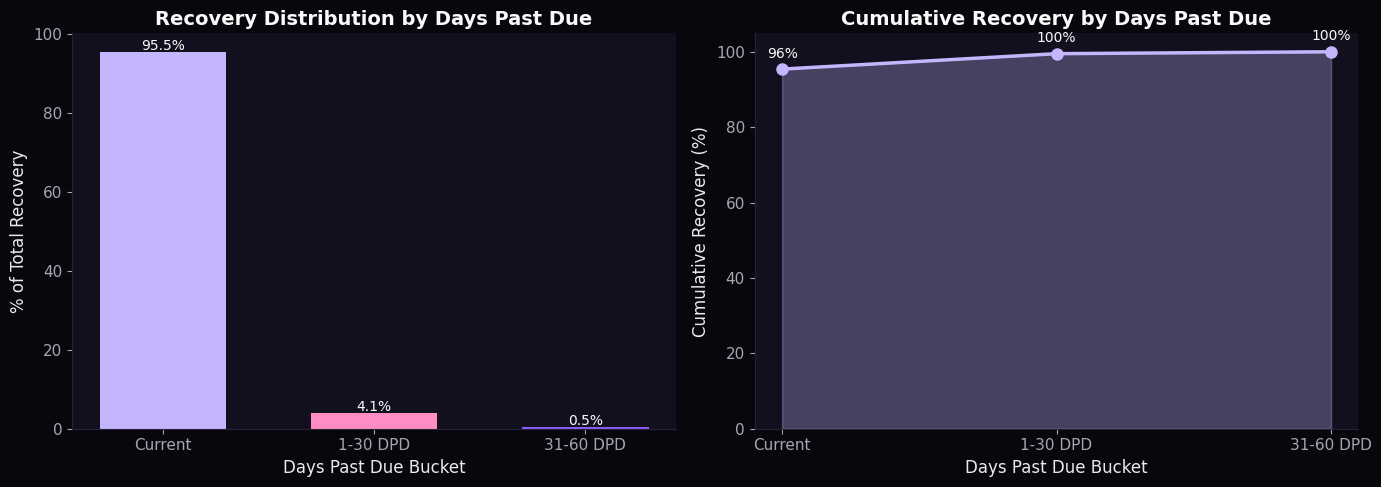


Recovery by Days Past Due:
dpd_bucket  payments  amount_recovered  pct_of_total  cumulative_pct
   Current     60780         982374.59          95.5            95.5
  1-30 DPD      3751          41953.03           4.1            99.6
 31-60 DPD       469           4699.66           0.5           100.1


In [8]:
# Load repayments data
repayments = pd.read_sql("SELECT * FROM public.repayments", create_engine(os.environ['TALA_CONNECTION_URL']))

# Join with loans to get total owed
repayments_with_loans = repayments.merge(df[['id', 'amount_usd', 'interest_rate', 'status', 'market']], 
                                          left_on='loan_id', right_on='id', suffixes=('', '_loan'))
repayments_with_loans['total_owed'] = repayments_with_loans['amount_usd_loan'] * (1 + repayments_with_loans['interest_rate'])

# Bucket days past due
dpd_bins = [0, 1, 30, 60, 90, 180, 9999]
dpd_labels = ['Current', '1-30 DPD', '31-60 DPD', '61-90 DPD', '91-180 DPD', '180+ DPD']
repayments_with_loans['dpd_bucket'] = pd.cut(repayments_with_loans['days_past_due'], bins=dpd_bins, 
                                              labels=dpd_labels, right=True, include_lowest=True)

# Recovery by DPD bucket
recovery_by_dpd = repayments_with_loans.groupby('dpd_bucket', observed=True).agg(
    payments=('id', 'count'),
    amount_recovered=('amount_usd', 'sum')
).reset_index()

# Total recoveries
total_recovered = repayments_with_loans['amount_usd'].sum()
recovery_by_dpd['pct_of_total'] = (recovery_by_dpd['amount_recovered'] / total_recovered * 100).round(1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Recovery distribution by DPD bucket
ax1 = axes[0]
bars = ax1.bar(recovery_by_dpd['dpd_bucket'].astype(str), recovery_by_dpd['pct_of_total'], 
               color=CATEGORICAL_PALETTE[:len(recovery_by_dpd)], width=0.6)
ax1.set_xlabel('Days Past Due Bucket')
ax1.set_ylabel('% of Total Recovery')
ax1.set_title('Recovery Distribution by Days Past Due', fontweight='bold')
for bar, pct in zip(bars, recovery_by_dpd['pct_of_total']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{pct}%', 
             ha='center', fontsize=10, color='#FAFAFA')

# 2. Cumulative recovery curve
recovery_by_dpd['cumulative_pct'] = recovery_by_dpd['pct_of_total'].cumsum()
ax2 = axes[1]
ax2.plot(recovery_by_dpd['dpd_bucket'].astype(str), recovery_by_dpd['cumulative_pct'], 
         marker='o', markersize=8, linewidth=2.5, color=COLORS['primary'])
ax2.fill_between(range(len(recovery_by_dpd)), recovery_by_dpd['cumulative_pct'], alpha=0.3, color=COLORS['primary'])
ax2.set_xlabel('Days Past Due Bucket')
ax2.set_ylabel('Cumulative Recovery (%)')
ax2.set_title('Cumulative Recovery by Days Past Due', fontweight='bold')
ax2.set_ylim(0, 105)
for i, (x, y) in enumerate(zip(range(len(recovery_by_dpd)), recovery_by_dpd['cumulative_pct'])):
    ax2.text(x, y + 3, f'{y:.0f}%', ha='center', fontsize=10, color='#FAFAFA')

plt.tight_layout()
plt.show()

print("\nRecovery by Days Past Due:")
print(recovery_by_dpd.to_string(index=False))